# A Tool for Scading in AutoCAD
(Reworked)

A rect is of the form `[lower point(x,y),Upper point(x,y)]`.
A shape is a (possibly empty) list of shapes and rects.
A figure is a (possibly empy) list of shapes.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as plticker
import copy

In [2]:
%xmode Verbose

Exception reporting mode: Verbose


In [3]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

In [4]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

In [5]:
colours={
    'Conductor':'Red',
    'Conductor2':'Red',
    'Oxide':'White',
    'Resist':'Cyan',
    'Silk':'Yellow'
}

##
# Units
##
mil = 1 # base units
mm = 40*mil # convertion to mils
inch = 1000*mil # convertion from in to mils

no_digits = lambda s: ''.join([i for i in s if not i.isdigit()])

env={
    'GRID':[1 * mm],
    'Wire Raidus':10,
    'Alignment Tolerance':15, # was 5 # about 10+
    'Pad Expantion':5,
    'AutoCAD Export':['GRID'],
}


# Basic Utility

In [6]:
def is_point(p):
    if type(p) not in [type([]),type((0,))]:
        return False
    if len(p)!=2:
        return False
    if type(p[0]) not in [type(0),type(0.0)]:
        return False
    if type(p[1]) not in [type(0),type(0.0)]:
        return False
    return True
def rect(x,y,w,h):
    if w<0:
        x+=w
        w*=-1
    if h<0:
        y+=h
        h*=-1
    return [(x,y),(w,h)]
def is_rect(RorS):
    if type(RorS)!=type([]):
        return False
    if len(RorS)!=2:
        return False
    return is_point(RorS[0]) and is_point(RorS[1])
def flatten(shape):
    if type(shape)!=type([]):
        raise ValueError("That's not a shape.")
    ret=[]
    for RorS in shape:
        if is_rect(RorS):
            ret.append(RorS)
        else:
            ret+=flatten(RorS)
    return ret
def simplify(shape):
    return shape
    # flatten
    shape = flatten(shape)
    # break each rect so that they don't interset with each other
    cleaned=[]
    while len(shape):
        r=shape.pop()
        #for r2 in shape or in cleaned:
        #    #for corner in r2:
        #    #    if corner in r:
        #    #        split r on corner
    # remove duplicate rects
    # merge rects
    return shape
def union(shape1,shape2):
    return [shape1,shape2]
def without(shape1,shape2):
    raise ValueError("TODO")
    return shape1
def expand(shape,delta_apothem):
    if is_rect(shape):
        return [[shape[0][0]-delta_apothem,
                 shape[0][1]-delta_apothem],
                [shape[1][0]+2*delta_apothem,
                 shape[1][1]+2*delta_apothem]]
    else:
        return list(expand(s,delta_apothem)
                    for s in shape)

In [7]:
def compile(**kwargs):
    ret=''
    def setup():
        e=''
        for k in env['AutoCAD Export']:
            v=env[k]
            e+=k+' '
            if len(v)>0:
                if type(v[0])==type([]):
                    for row in v:
                        for val in row:
                            e+=str(val)+' '
                        e=e[:-1] # trim trailing space
                        e+='\n' # start next row
                else:
                    for val in v:
                        e+=str(val)+' '
                    e=e[:-1] # trim trailing space
            e+='\n' # terminate command
        return e
    ret+=setup()
    for layer_name in kwargs:
        layer_items=flatten(kwargs[layer_name])
        ret+='-LAYER Make '+layer_name+'\n\n'
        if layer_name in colours:
            ret+='-LAYER Color '+colours[layer_name]+' '+layer_name+'\n\n'
        elif no_digits(layer_name) in colours:
            ret+='-LAYER Color '+colours[no_digits(layer_name)]+' '+layer_name+'\n\n'
        for rect in layer_items:
            cmd="RECTANG "
            # TODO: convert from mill to in
            ret+=cmd+"# "+str(round(rect[0][0])*mil/inch)+','+ \
                          str(round(rect[0][1])*mil/inch)+'\n'
            # Rounding all of the points to make defects more visable
            ret+="# "+str(round(rect[0][0]+rect[1][0])*mil/inch)+','+ \
                      str(round(rect[0][1]+rect[1][1])*mil/inch)+'\n'
            #ret+='\n'
    print(ret)

def render(**kwargs):
    #loc = plticker.MultipleLocator(base=env['GRID'][0])
    #plt.xaxis.set_major_locator(loc)
    #plt.yaxis.set_major_locator(loc)
    plt.grid(which='major',
             axis='both',
             linestyle=':',
             color='0.75',
             visible=True,
             markevery=5*env['GRID'])
    plt.grid(which='minor',
             axis='both',
             linestyle='-',
             color='0.50',
             visible=True,
             markevery=env['GRID'])
    for layer_name in kwargs:
        layer_items = kwargs[layer_name]
        c='Black'
        if layer_name in colours:
            c=colours[layer_name]
        elif no_digits(layer_name) in colours:
            c=colours[no_digits(layer_name)]
        def rect_to_points(rect):
            return [rect[0],
                    [rect[0][0]+rect[1][0],rect[0][1]],
                    [rect[0][0]+rect[1][0],rect[0][1]+rect[1][1]],
                    [rect[0][0],rect[0][1]+rect[1][1]],
                    rect[0]]
        for rect in flatten(layer_items):
            plt.plot(*zip(*rect_to_points(rect)),color=c)
            #plt.plot(rect_to_points(rect),color=c)

    automin, automax = plt.xlim()
    plt.xlim(automin-0.5, automax+0.5)
    automin, automax = plt.ylim()
    plt.ylim(automin-0.5, automax+0.5)
    plt.gca().set_facecolor('0.30')
    plt.show()

In [8]:
def wire(points):
    """
    This function assumes that only one dim changes at a time.
    (It will function if that is not true, but the rectangles won't align well.)
    """
    def wire_reduce(pnts):
        pnts=copy.deepcopy(pnts)
        pos=1
        while pos<len(pnts)-1:
            if (pnts[pos-1][0]==pnts[pos][0] and pnts[pos+1][0]==pnts[pos][0]) or \
               (pnts[pos-1][1]==pnts[pos][1] and pnts[pos+1][1]==pnts[pos][1]):
                pnts.pop(pos)
            else:
                pos+=1
        return pnts
    points=wire_reduce(points)
    if len(points)==0:
        return []
    if len(points)==1:
        # simple case
        p=points[0]
        wr=env['Wire Raidus']
        return [[p[0]-wr,p[1]+wr],
               [p[0]+wr,p[1]+wr],
               [p[0]+wr,p[1]-wr],
               [p[0]-wr,p[1]-wr]]
    else:
        def direct(p0,p1):
            d=[p1[0]-p0[0],
               p1[1]-p0[1]]
            l2=(d[0]**2+d[1]**2)**.5
            d[0]/=l2
            d[1]/=l2
            return d
        def rectp(p1,p2):
            return rect(p1[0],      p1[1],
                        p2[0]-p1[0],p2[1]-p1[1])
        wr=env['Wire Raidus']
        ret=[]
        for p1,p2 in zip(points[:-1],points[1:]):
            d=direct(p1,p2)
            d[0],d[1]=-d[0],-d[1]
            d[0],d[1]=d[0]+d[1],d[1]-d[0]
            d[0]*=wr
            d[1]*=wr
            ret.append(rectp([p1[0]+d[0],
                              p1[1]+d[1]],
                             [p2[0]-d[0],
                              p2[1]-d[1]]))
        return ret

In [9]:
def autoWire(pnts,shape):
    if type(shape)!=type(''):
        raise ValueError("Shape should be a char.")
    if shape=='v':
        if len(pnts)==2:
            # find bottom point
            bot=min(pnts[0][1],pnts[1][1])
            # shift it 3 wireRadi
            bot-=3*env['Wire Raidus']
            return autoWire([pnts[0],bot,pnts[1]],shape)
        if len(pnts)==3:
            return wire([pnts[0],
                         [pnts[0][0],pnts[1]],
                         [pnts[2][0],pnts[1]],
                         pnts[2]])
        raise ValueError("Don't know how to make a "+str(len(pnts))+" point 'v' curve.")
    if shape=='>':
        if len(pnts)==2:
            # find right point
            right=max(pnts[0][0],pnts[1][0])
            # shift it 3 wireRadi
            right+=3*env['Wire Raidus']
            return autoWire([pnts[0],right,pnts[1]],shape)
        if len(pnts)==3:
            return wire([pnts[0],
                         [pnts[1],pnts[0][0]],
                         [pnts[1],pnts[2][0]],
                         pnts[2]])
        raise ValueError("Don't know how to make a "+str(len(pnts))+" point '>' curve.")
    if shape=='^':
        if len(pnts)==2:
            # find top point
            top=max(pnts[0][1],pnts[1][1])
            # shift it 3 wireRadi
            top+=3*env['Wire Raidus']
            return autoWire([pnts[0],top,pnts[1]],shape)
        if len(pnts)==3:
            return wire([pnts[0],
                         [pnts[0][0],pnts[1]],
                         [pnts[2][0],pnts[1]],
                         pnts[2]])
        raise ValueError("Don't know how to make a "+str(len(pnts))+" point '^' curve.")
    if shape=='<':
        if len(pnts)==2:
            # find left point
            left=min(pnts[0][0],pnts[1][0])
            # shift it 3 wireRadi
            left-=3*env['Wire Raidus']
            return autoWire([pnts[0],left,pnts[1]],shape)
        if len(pnts)==3:
            return wire([pnts[0],
                         [pnts[1],pnts[0][0]],
                         [pnts[1],pnts[2][0]],
                         pnts[2]])
        raise ValueError("Don't know how to make a "+str(len(pnts))+" point '<' curve.")
    if shape=='wide-s':
        f='y-first'
        if abs(pnts[0][0]-pnts[-1][0])>abs(pnts[0][1]-pnts[-1][1]):
            f='x-first'
        if len(pnts)==2:
            pnts=[pnts[0],
                  [(pnts[0][0]+pnts[1][0])/2,(pnts[0][1]+pnts[1][1])/2],
                  pnts[1]]
        if len(pnts)==3:
            return flatten([autoWire([pnts[0],pnts[1]],f),
                            autoWire([pnts[2],pnts[1]],f)[::-1]])
        raise ValueError("Don't know how to make a "+str(len(pnts))+" point 'wide-s' curve.")
    if shape=='narrow-s' or shape=='tall-s':
        f='x-first'
        if abs(pnts[0][0]-pnts[-1][0])>abs(pnts[0][1]-pnts[-1][1]):
            f='y-first'
        if len(pnts)==2:
            pnts=[pnts[0],
                  [(pnts[0][0]+pnts[1][0])/2,(pnts[0][1]+pnts[1][1])/2],
                  pnts[1]]
        if len(pnts)==3:
            return flatten([autoWire([pnts[0],pnts[1]],f),
                            autoWire([pnts[2],pnts[1]],f)[::-1]])
        raise ValueError("Don't know how to make a "+str(len(pnts))+" point 'narrow-s' curve.")
    if shape=='x-first':
        if len(pnts)==2:
            return wire([pnts[0],
                        [pnts[1][0],pnts[0][1]],
                        pnts[1]])
        raise ValueError("Don't know how to make a "+str(len(pnts))+" point 'x-first' curve.")
    if shape=='y-first':
        if len(pnts)==2:
            return wire([pnts[0],
                        [pnts[0][0],pnts[1][1]],
                        pnts[1]])
        raise ValueError("Don't know how to make a "+str(len(pnts))+" point 'y-first' curve.")
    raise ValueError("Don't know how to make a '"+shape+"' curve.")

# Object Inspection

In [10]:
def top_right(obj):
    if is_rect(obj):
        return (obj[0][0]+obj[1][0],
                obj[0][1]+obj[1][1])
    l=list(top_right(s) for s in obj)
    return (max(p[0] for p in l),
            max(p[1] for p in l))

def bot_right(obj):
    if is_rect(obj):
        return (obj[0][0]+obj[1][0],
                obj[0][1])
    l=list(bot_right(s) for s in obj)
    return (max(p[0] for p in l),
            min(p[1] for p in l))

def top_left(obj):
    if is_rect(obj):
        return (obj[0][0],
                obj[0][1]+obj[1][1])
    l=list(top_left(s) for s in obj)
    return (min(p[0] for p in l),
            max(p[1] for p in l))

def bot_left(obj):
    if is_rect(obj):
        return obj[0]
    l=list(bot_left(s) for s in obj)
    return (min(p[0] for p in l),
            min(p[1] for p in l))

# These funcitons assume the object is a rectangle
def mid_pnt(p1,p2):
    return ((p1[0]+p2[0])/2,
            (p1[1]+p2[1])/2)
def top_center(obj):
    tl=top_left(obj)
    tr=top_right(obj)
    return mid_pnt(tl,tr)
def right_center(obj):
    tr=top_right(obj)
    br=bot_right(obj)
    return mid_pnt(tr,br)
def bot_center(obj):
    bl=bot_left(obj)
    br=bot_right(obj)
    return mid_pnt(bl,br)
def left_center(obj):
    tl=top_left(obj)
    bl=bot_left(obj)
    return mid_pnt(tl,bl)
def bound_rect(obj):
    bl=bot_left(obj)
    tl=top_left(obj)
    tr=top_right(obj)
    br=bot_right(obj)
    return [bl,tl,tr,br]

def center(obj):
    rect=bound_rect(obj)
    return [(rect[0][0]+rect[1][0]+rect[2][0]+rect[3][0])/4,
            (rect[0][1]+rect[1][1]+rect[2][1]+rect[3][1])/4]

def MinWidth(shape):
    if is_rect(shape):
        return min(*shape[1])
    else:
        return min(MinWidth(r)
                   for r in shape)

# Object Transforms

In [11]:
def move(obj,pos):
    if is_rect(obj):
        return [[obj[0][0]+pos[0],
                 obj[0][1]+pos[1]],
                obj[1]]
    else:
        return list(move(s,pos)
                    for s in obj)

def rotate90(obj,pivot=None):
    if pivot==None:
        pivot=center(obj)
    if is_rect(obj):
        def pnt_rot(piv,pnt):
            pnt[0],pnt[1]=pnt[0]-piv[0],pnt[1]-piv[1]
            pnt[0],pnt[1]=-pnt[1],pnt[0]
            pnt[0],pnt[1]=pnt[0]+piv[0],pnt[1]+piv[1]
            return pnt
        rect=[obj[0],
              (obj[1][1],
               obj[1][0])]
        mov=pnt_rot(pivot,center(obj))
        c=center(rect)
        mov=[mov[0]-c[0],
             mov[1]-c[1]]
        return move(rect,mov)
    else:
        return list(rotate90(shape,pivot)
                    for shape in obj)

def rotate270(obj,pivot=None):
    if pivot==None:
        pivot=center(obj)
    if is_rect(obj):
        def pnt_rot(piv,pnt):
            pnt[0],pnt[1]=pnt[0]-piv[0],pnt[1]-piv[1]
            pnt[0],pnt[1]=pnt[1],-pnt[0]
            pnt[0],pnt[1]=pnt[0]+piv[0],pnt[1]+piv[1]
            return pnt
        rect=[obj[0],
              (obj[1][1],
               obj[1][0])]
        mov=pnt_rot(pivot,center(obj))
        c=center(rect)
        mov=[mov[0]-c[0],
             mov[1]-c[1]]
        return move(rect,mov)
    else:
        return list(rotate720(shape,pivot)
                    for shape in obj)

def rotate(obj,amount,pivot=None):
    """Amount is in quarter turns"""
    amount%=4
    if amount==0:
        return obj
    elif amount==1:
        return rotate90(obj,pivot)
    elif amount==2:
        return rotate90(rotate90(obj,pivot),pivot)
    elif amount==3:
        return rotate270(obj,pivot)
    else:
        raise ValueError("Unknown number",amount)

def alignment_pad(center_or_rect):
    if is_point(center_or_rect):
        c = center_or_rect
        return [rect(c[0]-env['Wire Raidus']-env['Alignment Tolerance'],
                     c[1]-env['Wire Raidus']-env['Alignment Tolerance'],
                     2*env['Wire Raidus']+2*env['Alignment Tolerance'],
                     2*env['Wire Raidus']+2*env['Alignment Tolerance'])]
    elif is_rect(center_or_rect):
        r=center_or_rect
        c=center(r)
        g=max([env['Alignment Tolerance'],
               env['Wire Raidus']-MinWidth(r)])
        return list([g*(p[0]-c[0])/abs(p[0]-c[0])+p[0],
                     g*(p[1]-c[1])/abs(p[1]-c[1])+p[1]]
                    for p in r)
    else:
        raise ValueError("Not a point or rectangle")

def solder_pad(shape):
    c=center(shape)
    g=max([env['Pad Expantion'],
           2*env['Wire Raidus']-MinWidth(shape)])
    return expand(shape,g)

# Component Library

In [12]:
CeramicBoundry=[rect(0,0,.6*inch,.6*inch),
                rect(2*env['Wire Raidus'],
                     2*env['Wire Raidus'],
                     .6*inch-4*env['Wire Raidus'],
                     .6*inch-4*env['Wire Raidus'])]

LM324_Silk=[
    rect(0,0,8.6 * mm, 3.9 * mm), # modify with notch
   *list(rect(1.27 * mm * leg + (8.6-(1.27*(7-1)+.4))/2*mm,
              3.90 * mm * is_top,
              0.40 * mm,
              1.20 * mm *2*(is_top-.5))
         for is_top in [0,1]
         for leg in range(7)[::(1-2*is_top)])
]

def silk_to_pad(obj):
    """Assumes that the obj is of the form [boundry,contact,contact,...]."""
    recs=obj[1:]
    recs=list(solder_pad(foot) for foot in recs)
    return recs

LM324_Pad=silk_to_pad(LM324_Silk)

def cap_silk(ID):
    """Returns the outline and a silk of the pads."""
    if ID=="293D226X0016D2T":
        # https://www.mouser.com/datasheet/2/427/293d-239871.pdf
        # D case
        return [rect(0,0,7.3 * mm,4.3 * mm),
                rect(0,(4.3-2.4)/2*mm,1.3*mm,2.4*mm),
                rect((7.3-1.4)*mm,(4.3-2.4)/2*mm,1.3*mm,2.4*mm)]
    if ID=="35MC105KBTER":
        # https://www.datasheets360.com/pdf/-6726743588809183636
        # UCC Case B
        return [rect(0.2 * mm, 0.0 * mm, 4.3 * mm, 2.6 * mm),
                rect(0.0 * mm, 0.4 * mm, 0.9 * mm, 1.8 * mm),
                rect(3.8 * mm, 0.4 * mm, 0.9 * mm, 1.8 * mm)]
    else:
        raise ValueError("Unknown cap "+str(ID))

def cap_pad(ID):
    return silk_to_pad(cap_silk(ID))
    #make the right size
    return recs

def resistor_silk(ID):
    """Returns the outline and a silk of the pads."""
    if ID=='KTR03EZPF1005':
        return [rect(0,0,1.6*mm,.8*mm),
                rect(0,0,.3*mm,.8*mm),
                rect(1.3*mm,0,.3*mm,.8*mm)]
    if ID=="0603":
        return [rect(0,0,1.6*mm,0.8*mm),
                rect(0,0,.3*mm,.8*mm),
                rect(1.3*mm,0,.3*mm,.8*mm)]
    if ID=="1206":
        return [rect(0,0,3.2*mm,1.6*mm),
                rect(0,0,.5*mm,1.6*mm),
                rect(2.7*mm,0,.5*mm,1.6*mm)]
    else:
        raise ValueError("Unknown resistor "+str(ID))

def resistor_pad(ID):
    return silk_to_pad(resistor_silk(ID))
    #make the right size
    return recs

gator_pad=[rect(0,0,2*mm,4*mm)]

# SCAD File

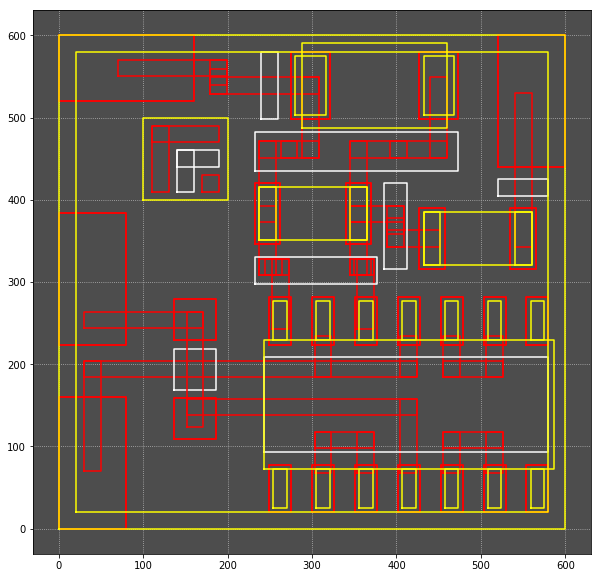

In [13]:
##
# Place Pads
##

GND_pad=move(gator_pad,[0*mm,0*mm])
Vin_pad=move(gator_pad,[top_right(CeramicBoundry[0])[0]-top_right(gator_pad[0])[0],11*mm])

##
# Create and Position Components
##

wr=env['Wire Raidus']
at=env['Alignment Tolerance']
pa=env['Pad Expantion']

U1_pad=LM324_Pad
U1_silk=LM324_Silk
C1_pad=cap_pad("35MC105KBTER")
C1_silk=cap_silk("35MC105KBTER")
R1_pad=resistor_pad("1206")
R1_silk=resistor_silk("1206")
R2_pad=resistor_pad("1206")
R2_silk=resistor_silk("1206")

U1Pos=(bot_right(CeramicBoundry[1])[0]-bot_right(U1_pad)[0],
       bot_right(CeramicBoundry[1])[1]-bot_right(U1_pad)[1])
U1rot=0
U1_pad=move(rotate(U1_pad,U1rot),U1Pos)
U1_silk=move(rotate(U1_silk,U1rot),U1Pos)

##
# Connect Compnents and Pads
##

jumps=[]
jump_pads=[]
solder_dams=[]
covers=[]

Vin_node=[]
Vout_node=[]
Vpos_node=[]
GND_node=[]
fb_node=[]
shorts=[]

# short the unused opamps
shorts+=autoWire([top_center(U1_pad[1]),top_center(U1_pad[2])],'^')
shorts+=autoWire([top_center(U1_pad[4]),top_center(U1_pad[5])],'^')
shorts+=autoWire([bot_center(U1_pad[8]),bot_center(U1_pad[9])],'v')
# gnd (10,12,pad)
GND_node+=autoWire([bot_center(U1_pad[10]),
                    (bot_center(U1_pad[10])[0],center(shorts[-2])[1]), #same height as the other v
                    center(GND_pad)],'tall-s')
GND_node+=wire([bot_center(U1_pad[12]),
                (bot_center(U1_pad[12])[0],
                 center(GND_node[1])[1])])
# pos from 3 to pad
## going to add the jump here
covers+=alignment_pad(((right_center(GND_pad)[0]+left_center(U1_silk)[0])/2,center(GND_node[1])[1]))
cover_apoth=center(covers[0])[1]-bot_center(covers[0])[1]
jump_pads+=alignment_pad((center(covers[0])[0],center(covers[0])[1]-2*cover_apoth-wr))
jump_pads+=alignment_pad((center(covers[0])[0],center(covers[0])[1]+2*cover_apoth+wr))
jumps=wire([center(jump_pads[-2]),center(jump_pads[-1])])
Vpos_node+=autoWire([top_center(U1_pad[3]),
                     (center(jump_pads[-2])[0],
                      4*wr+center(shorts[1])[1])],'y-first')
Vpos_pad=move(gator_pad,(0,center(jump_pads[-1])[1]-3*wr))
Vpos_node+=[autoWire([center(jump_pads[-1]),
                     bot_center(Vpos_pad)],'x-first')[0]]

##
# Time to place the components
##

C1Pos=[7*mm,top_right(CeramicBoundry[1])[1]-top_right(C1_pad[0])[1]]
C1_pad=move(C1_pad,C1Pos)
C1_silk=move(C1_silk,C1Pos)
C1rot=2
C1_pad=rotate(C1_pad,C1rot)
C1_silk=rotate(C1_silk,C1rot)
R1rot=2
R1_pad=rotate(R1_pad,R1rot)
R1_silk=rotate(R1_silk,R1rot)
R1Pos=(top_right(CeramicBoundry[1])[0]-top_right(R1_pad)[0],
       bot_center(Vin_pad)[1]-5*wr    -top_right(R1_pad)[1])
R1_pad=move(R1_pad,R1Pos)
R1_silk=move(R1_silk,R1Pos)
Vout_pad=rotate(gator_pad,1)
Vout_pad=move(Vout_pad,(top_left(CeramicBoundry)[0]-top_left(Vout_pad)[0],
                        top_left(CeramicBoundry)[1]-top_left(Vout_pad)[1]))
R2rot=2
R2_pad=rotate(R2_pad,R2rot)
R2_silk=rotate(R2_silk,R2rot)
R2Pos=(center(U1_pad[-1])[0] -center(R2_pad[1])[0],
       center(R1_pad)[1]+3*wr-center(R2_pad[0])[1])
R2_pad=move(R2_pad,R2Pos)
R2_silk=move(R2_silk,R2Pos)

## reverse hot patch from while making solder dams
fix_delta=(-at,0)
R1_pad=move(R1_pad,fix_delta)
R1_silk=move(R1_silk,fix_delta)
R2_pad=move(R2_pad,fix_delta)
R2_silk=move(R2_silk,fix_delta)
## end patch


##
# moar wires
##
Vin_node+=[autoWire([center(Vin_pad),
                    center(R1_pad[0])],
                   'x-first')[1]]
fb_node+=autoWire([center(R1_pad[1]),
                   center(R2_pad[0])],
                  'wide-s')
fb_node+=autoWire([center(U1_pad[-3]),
                   center(R2_pad[0])],
                  'wide-s')
fb_node+=autoWire([center(C1_pad[0]),
                   center(R2_pad[0])],
                  'wide-s')
Vout_node+=autoWire([center(U1_pad[-1]),
                     center(R2_pad[1])],
                    'wide-s')
Vout_node+=autoWire([center(C1_pad[1]),
                     center(R2_pad[1])],
                    'wide-s')
Vout_node+=autoWire([center(C1_pad[1]),
                     center(Vout_pad)],
                    'wide-s')

def rectp(p1,p2):
    return rect(p1[0],
                p1[1],
                p2[0]-p1[0],
                p2[1]-p1[1])

covers+=[rectp((bot_left(U1_silk[0])[0],
                bot_left(U1_silk[0])[1]+at+.5*wr),
               (bot_right(CeramicBoundry[1])[0],
                top_right(U1_silk[0])[1]-at-.5*wr))]
covers+=[rectp((bot_left(R1_pad)[0]-at,
                bot_left(R1_pad)[1]),
               (top_right(R2_pad)[0]+at,
                top_right(R2_pad)[1]))]
covers+=[rectp((top_left(R2_pad)[0],
                top_left(R2_pad)[1]+at),
               (bot_right(C1_pad)[0],
                bot_right(C1_pad)[1]-at))]
covers+=[rectp((top_left(R1_pad[0])[0]-at,
                top_left(R1_pad[0])[1]+at),
               (right_center(CeramicBoundry[1])[0],
                bot_right(Vin_pad)[1]-at))]
## made reverse hot patch at this point
covers+=[rectp((top_right(U1_pad[-3])[0],
                top_right(U1_pad[-3])[1]+at),
               (bot_left(R2_pad)[0],
                bot_left(R2_pad)[1]-at))]

covers+=[rectp((bot_left(C1_pad[1])[0]-at,
                bot_left(C1_pad[1])[1]),
               (top_left(C1_pad[1])[0]-2*wr-at,
                top_left(C1_pad[1])[1]))]

##

alignment=[]
alignment+=[rect(100,400,100,100),
            [rect(100+1*wr,400+7*wr,8*wr,2*wr),
             rect(100+1*wr,400+1*wr,2*wr,8*wr)],
            [rect(100+4*wr,400+4*wr,5*wr,2*wr),
             rect(100+4*wr,400+1*wr,2*wr,5*wr)],
            rect(100+7*wr,400+wr,2*wr,2*wr)]

##

wires=[shorts,Vin_node,Vout_node,Vpos_node,GND_node,fb_node,]
pads=[Vpos_pad,Vin_pad,GND_pad,Vout_pad,U1_pad,C1_pad,R1_pad,R2_pad,jump_pads,]
Conductor1=[wires,pads,alignment[-3]]
Oxide=[solder_dams,covers,alignment[-2]]
Conductor2=[jumps,pads,alignment[-1]]
Silk=[CeramicBoundry,U1_silk,C1_silk,R1_silk,R2_silk,alignment[0]]
render(Conductor1=Conductor1,Oxide=Oxide,Conductor2=Conductor2,Silk=Silk)
#compile(Conductor1=Conductor1,Oxide=Oxide,Conductor2=Conductor2,Silk=Silk)

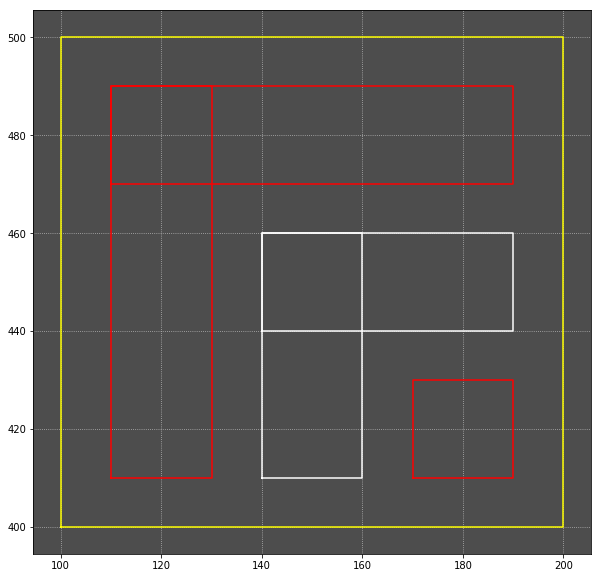

In [14]:
render(Conductor1=[alignment[-3]],Oxide=[alignment[-2]],Conductor2=[alignment[-1]],Silk=[alignment[0]])

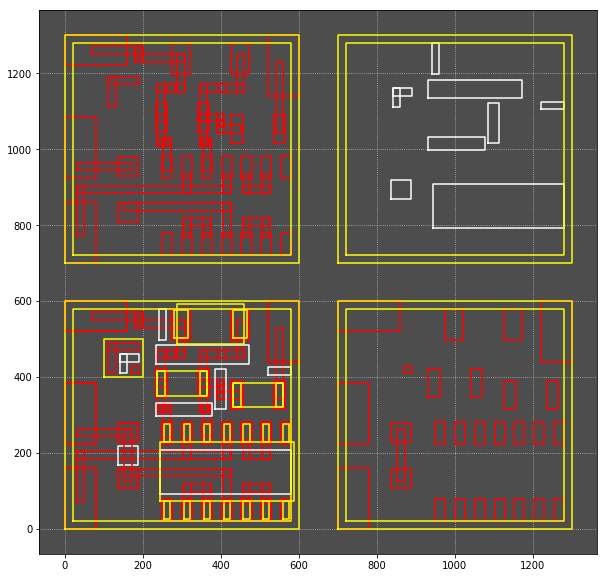

'\ncompile(Conductor1=[Conductor1,\n                    move(flatten(Conductor1),(0,700))],\n        Oxide=[Oxide,\n               move(flatten(Oxide),(700,700))],\n        Conductor2=[Conductor2,\n                    move(flatten(Conductor2),(700,0))],\n        Silk=[Silk,\n              move(CeramicBoundry,(0,700)),\n              move(CeramicBoundry,(700,0)),\n              move(CeramicBoundry,(700,700))])\n#'

In [15]:
render(Conductor1=[Conductor1,
                   move(flatten(Conductor1),(0,700))],
       Oxide=[Oxide,
              move(flatten(Oxide),(700,700))],
       Conductor2=[Conductor2,
                   move(flatten(Conductor2),(700,0))],
       Silk=[Silk,
             move(CeramicBoundry,(0,700)),
             move(CeramicBoundry,(700,0)),
             move(CeramicBoundry,(700,700))])
"""
compile(Conductor1=[Conductor1,
                    move(flatten(Conductor1),(0,700))],
        Oxide=[Oxide,
               move(flatten(Oxide),(700,700))],
        Conductor2=[Conductor2,
                    move(flatten(Conductor2),(700,0))],
        Silk=[Silk,
              move(CeramicBoundry,(0,700)),
              move(CeramicBoundry,(700,0)),
              move(CeramicBoundry,(700,700))])
#"""

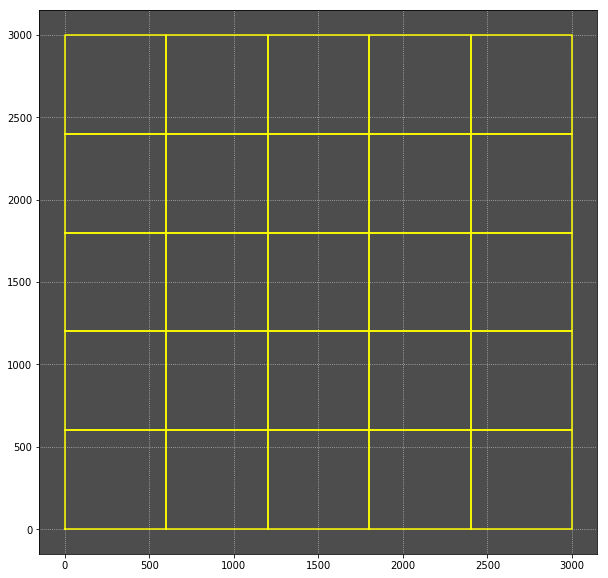

GRID 40
-LAYER Make Silk

-LAYER Color Yellow Silk

RECTANG # 4.0,0.0
# 4.6,0.6
RECTANG # 4.0,0.6
# 4.6,1.2
RECTANG # 4.0,1.2
# 4.6,1.8
RECTANG # 4.0,1.8
# 4.6,2.4
RECTANG # 4.0,2.4
# 4.6,3.0
RECTANG # 4.6,0.0
# 5.2,0.6
RECTANG # 4.6,0.6
# 5.2,1.2
RECTANG # 4.6,1.2
# 5.2,1.8
RECTANG # 4.6,1.8
# 5.2,2.4
RECTANG # 4.6,2.4
# 5.2,3.0
RECTANG # 5.2,0.0
# 5.8,0.6
RECTANG # 5.2,0.6
# 5.8,1.2
RECTANG # 5.2,1.2
# 5.8,1.8
RECTANG # 5.2,1.8
# 5.8,2.4
RECTANG # 5.2,2.4
# 5.8,3.0
RECTANG # 5.8,0.0
# 6.4,0.6
RECTANG # 5.8,0.6
# 6.4,1.2
RECTANG # 5.8,1.2
# 6.4,1.8
RECTANG # 5.8,1.8
# 6.4,2.4
RECTANG # 5.8,2.4
# 6.4,3.0
RECTANG # 6.4,0.0
# 7.0,0.6
RECTANG # 6.4,0.6
# 7.0,1.2
RECTANG # 6.4,1.2
# 7.0,1.8
RECTANG # 6.4,1.8
# 7.0,2.4
RECTANG # 6.4,2.4
# 7.0,3.0
RECTANG # 8.0,0.0
# 8.6,0.6
RECTANG # 8.0,0.6
# 8.6,1.2
RECTANG # 8.0,1.2
# 8.6,1.8
RECTANG # 8.0,1.8
# 8.6,2.4
RECTANG # 8.0,2.4
# 8.6,3.0
RECTANG # 8.6,0.0
# 9.2,0.6
RECTANG # 8.6,0.6
# 9.2,1.2
RECTANG # 8.6,1.2
# 9.2,1.8
RECTANG # 8.6,1.8
# 9.2,

In [16]:
ceramicGrid=[move(CeramicBoundry[0],(x*top_right(CeramicBoundry)[0],
                                  y*top_right(CeramicBoundry)[1],))
             for x,y in np.ndindex((5,5))]
render(Silk=ceramicGrid)
#compile(Silk=ceramicGrid)
compile(Silk=[move(ceramicGrid,(4000,0)),move(ceramicGrid,(8000,0)),move(ceramicGrid,(12000,0))])

In [25]:
colours={
    'Conductor':'Black',
    'Conductor2':'Black',
    'Oxide':'Red',
    'Resist':'Cyan',
    'Silk':'Yellow'
}

def render_print(**kwargs):
    plt.grid(which='major',
             axis='both',
             linestyle=':',
             color='0.75',
             visible=True,
             markevery=5*env['GRID'])
    plt.grid(which='minor',
             axis='both',
             linestyle='-',
             color='0.50',
             visible=True,
             markevery=env['GRID'])
    for layer_name in kwargs:
        layer_items = kwargs[layer_name]
        c='Black'
        if layer_name in colours:
            c=colours[layer_name]
        elif no_digits(layer_name) in colours:
            c=colours[no_digits(layer_name)]
        def rect_to_points(rect):
            return [rect[0],
                    [rect[0][0]+rect[1][0],rect[0][1]],
                    [rect[0][0]+rect[1][0],rect[0][1]+rect[1][1]],
                    [rect[0][0],rect[0][1]+rect[1][1]],
                    rect[0]]
        for rect in flatten(layer_items):
            plt.plot(*zip(*rect_to_points(rect)),color=c)
            #plt.plot(rect_to_points(rect),color=c)

    automin, automax = plt.xlim()
    plt.xlim(automin-0.5, automax+0.5)
    automin, automax = plt.ylim()
    plt.ylim(automin-0.5, automax+0.5)
    plt.gca().set_facecolor('1.0')
    plt.show()

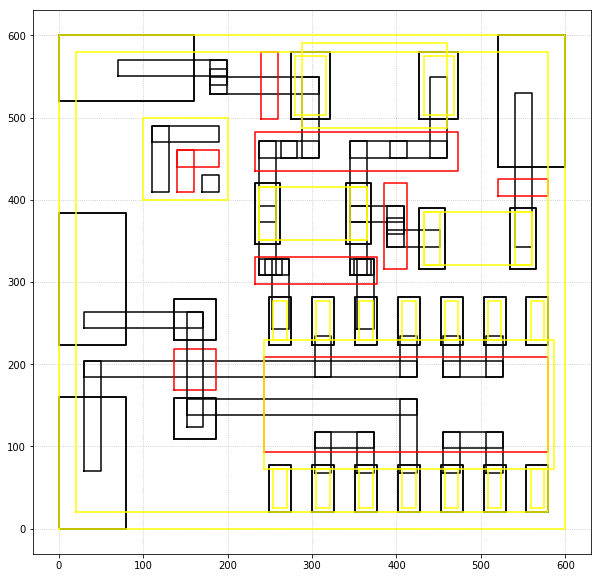

In [26]:
render_print(Conductor1=Conductor1,Oxide=Oxide,Conductor2=Conductor2,Silk=Silk)